30step後の地図


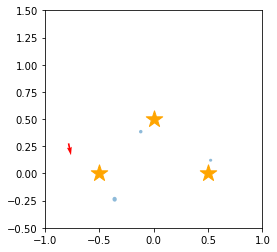

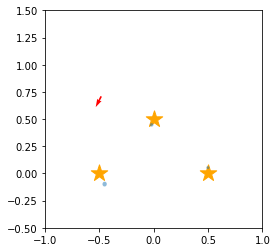

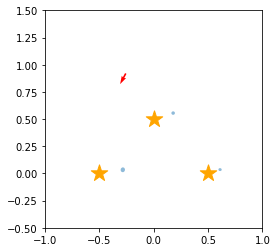

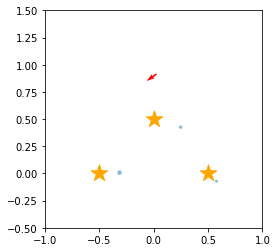

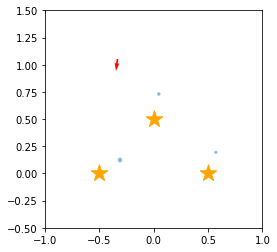

In [16]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


#ランドマークのクラス
class Landmark:
    def __init__(self,x,y):
        self.pos = np.array([[x],[y]])
        
    def draw(self):
        plt.scatter(xs, ys, s=300, marker="*", label="landmarks", color="orange")
        
    def relative_pos(self,pose):
        x,y,theta = pose
        lx,ly = self.pos[0][0],self.pos[1][0]
        distance = math.sqrt((x-lx)**2 + (y-ly)**2)
        direction = math.atan2(ly-y, lx-x) - theta
        
        return (distance, direction,lx,ly)
    
    
#地図のクラス
class Map():
    def __init__(self):
        self.landmarks = []
        
    def append_landmark(self,x,y):
        self.landmarks.append(Landmark(x,y))
        
    def draw(self):
        xs = [ e.pos[0] for e in self.landmarks]
        ys = [ e.pos[1] for e in self.landmarks]
        plt.scatter(xs, ys, s=300, marker="*", label="landmarks", color="orange")
        
    def relative_landmark_positions(self,pose):
        positions = []
        for i,ln in enumerate(self.landmarks):
            distance, direction, lx, ly = ln.relative_pos(pose)
            positions.append([distance, direction, lx, ly, i])
            
        return positions

    
#正解の地図m*を作る
m = Map()
m.append_landmark(-0.5,0.0)
m.append_landmark(0.5,0.0)
m.append_landmark(0.0,0.5)

#m.draw()


#ロボットのクラス
class Robot:
    def __init__(self,pose):
        self.pose = pose
        
    def draw(self):
        x,y,theta = self.pose
        plt.quiver([x],[y],[math.cos(theta)],[math.sin(theta)],color="red",label="actual robot motion")
        
    def observation(self,m):
        measurements = m.relative_landmark_positions(self.pose)
        observations = []
        
        for m in measurements:
            distance, direction,lx,ly, i = m
            if (math.cos(direction) < 0.0): continue
    
            measured_distance = random.gauss(distance,distance*0.1)  
            measured_direction = random.gauss(direction,5.0/180.0*math.pi)
            observations.append([measured_distance, measured_direction,lx,ly,i])  
        
        return observations
    
    def motion_model(self, pos, fw, rot):
        actual_fw = random.gauss(fw,fw/10)
        dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)

        px, py, pt = pos

        x = px + actual_fw * math.cos(pt + dir_error)
        y = py + actual_fw * math.sin(pt + dir_error)

        t = pt + dir_error + random.gauss(rot,rot/10)

        return np.array([x,y,t])

    
#描画
robot = Robot(np.array([0.1,0.2,math.pi*20.0/180]))
#robot.draw()
#m.draw()


#ランドマークの推定結果
class LandmarkEstimation():
    def __init__(self):
        self.pos = np.array([[0.0],[0.0]])
        self.cov = np.array([[1000000000.0**2,0.0],[0.0,1000000000.0**2]])
        

#パーティクルのクラス
class Particle():
    def __init__(self,pose,w):
        self.w = w
        self.pose = pose
        self.map = [LandmarkEstimation(),LandmarkEstimation(),LandmarkEstimation()]
        
    def motion_update(self, fw, rot, robot):
        self.pose = robot.motion_model(self.pose, fw, rot)
        
    def measurement_update(self, measurement):
        x,y,theta = self.pose
        distance, direction,lx,ly,i = measurement
        ln = self.map[i]
        lx = distance*math.cos(theta + direction) + x
        ly = distance*math.sin(theta + direction) + y
        
        delta = np.array([[x],[y]]) - np.array([[lx],[ly]])
        coef = 2*math.pi * math.sqrt(np.linalg.det(ln.cov))
        inexp = -0.5 * (delta.T.dot(np.linalg.inv(ln.cov))).dot(delta)
        self.w *= 1.0/coef * math.exp(inexp)
        
        z = np.array([[lx],[ly]])
        
        c = math.cos(theta + direction)
        s = math.sin(theta + direction)
        rot = np.array([[ c,s],[-s,c]])
        
        err_robot = np.array([[(distance*0.1)**2,0.0],
                             [0.0,(distance*math.sin(5.0/180.0*math.pi))**2]])
        err_world = (rot).dot(err_robot).dot((rot).T)
        
        ln.cov = np.linalg.inv(np.linalg.inv(ln.cov) + np.linalg.inv(err_world))
        K = (ln.cov).dot(np.linalg.inv(err_world))
        ln.pos += K.dot( z - ln.pos )
        
    def draw(self,i):
        fig = plt.figure(i,figsize=(4,4))
        sp = fig.add_subplot(111, aspect='equal')
        sp.set_xlim(-1.0,1.0)
        sp.set_ylim(-0.5,1.5)
        
        m.draw()
        x,y,theta = self.pose
        plt.quiver([x],[y],[math.cos(theta)],[math.sin(theta)],color="red",label="actual robot motion")
        
        for e in self.map:
            eigen = np.linalg.eig(e.cov)
            v1 = eigen[0][0] * eigen[1][0]
            v2 = eigen[0][1] * eigen[1][1]
            v1_direction = math.atan2(v1[1],v1[0])
            
            x,y = e.pos
            elli = Ellipse([x,y],width=3*math.sqrt(np.linalg.norm(v1)),height=3*math.sqrt(np.linalg.norm(v2)),angle=v1_direction/3.14*180)
            elli.set_alpha(0.5)
            
            sp.add_artist(elli)
            
            
#FastLAMのクラス
import copy

class FastSLAM():
    def __init__(self,pose):
        self.particles = [Particle(pose,1.0/100) for i in range(100)]
        
    def draw(self):
        for (i,p) in enumerate(self.particles):
            p.draw(i)
            if i > 3: return
            
    def motion_update(self, fw, rot, robot):
        for p in self.particles:
            p.motion_update(fw,rot, robot)
            
    def measurement_update(self, measurement):
        for p in self.particles:
            p.measurement_update(measurement)
            
        self.resampling()
        
    def resampling(self):
        num = len(self.particles)
        ws = [e.w for e in self.particles]
        
        if sum(ws) < 1e-100:
            ws = [e + 1e-100 for e in ws]
            
        ps = random.choices(self.particles, weights=ws, k=num)
        
        self.particles = [copy.deepcopy(e) for e in ps]
        
        
#初期状態
robot.pose = np.array([0.0,0.0,0.0])
slam = FastSLAM(robot.pose)
#slam.draw()


#30ステップ後のパーティクル
def one_step(m):
    slam.motion_update(0.2, math.pi / 180.0 * 20, robot)
    robot.pose = robot.motion_model(robot.pose, 0.2, math.pi / 180.0 * 20)
    measurements = robot.observation(m)
    for m in measurements:
        slam.measurement_update(m)
        
n = 30
for i in range(n):
    one_step(m)
    
print(str(n) + "step後の地図")
slam.draw()